# Multi output model with two outputs which are needed to be produced for the data analysis and predictions

# DeepLearning.AI Specialization: TensorFlow: Advanced Techniques

In [6]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, Input 
from sklearn.model_selection import train_test_split 


In [7]:
# func to retrieve Y1 and Y2 columns 
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2

# normalize input data (x)
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

# function to visualize 
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


# function to visualize 
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

In [8]:
# Specify data path
data_path = '/kaggle/input/energy-efficiency-prediction/energy_efficiency_prediction.xlsx'

# Use pandas excel reader
df = pd.read_excel(data_path)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

# Building model using functional syntax  

In [9]:
# model layers 
input_layer = Input(shape = (len(train.columns),))
first_dense = Dense(units = 128, activation = 'relu')(input_layer)
second_dense = Dense(units = 128, activation = 'relu')(first_dense)

# Y1 output will be fed directly from the second dense 
y1_output = Dense(units = 1, name = 'y1_output')(second_dense)
third_dense = Dense(units = 64, activation = 'relu')(second_dense)

# Y2 output will come via the third dense 
y2_output = Dense(units = 1, name = 'y2_output')(third_dense)

# define the model with the input layer and a list of output layers 
model = Model(inputs = input_layer, outputs = [y1_output, y2_output]) 

print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      1,152 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     16,512 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y1_output (Dense)   │ (None, 1)         │        129 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y2_output (Dense)   │ (None, 1)         │         65 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,114 (102.01 KB)

 Trainable params: 26,114 (102.01 KB)

 Non-trainable params: 0 (0.00 B)

None


In [16]:
# configuration 
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001)
model.compile(

    optimizer = optimizer,
    loss = {'y1_output': 'mse', 'y2_output': 'mse'},
    metrics = {'y1_output': ['mse',tf.keras.metrics.RootMeanSquaredError()],
               'y2_output': ['mse',tf.keras.metrics.RootMeanSquaredError()]}
)


In [ ]:
# training the model 
history = model.fit(norm_train_X, train_Y, epochs = 500, batch_size = 10,
                   validation_data = (norm_test_X, test_Y))



In [17]:
# here we will print the loss and mse for both outputs 
a = model.evaluate(x = norm_test_X, y = test_Y) 
print(a)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1806 - y1_output_mse: 0.3963 - y1_output_root_mean_squared_error: 0.6278 - y2_output_mse: 0.7843 - y2_output_root_mean_squared_error: 0.8806  
[0.975166916847229, 0.35132896900177, 0.5927301049232483, 0.623837947845459, 0.7898341417312622]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


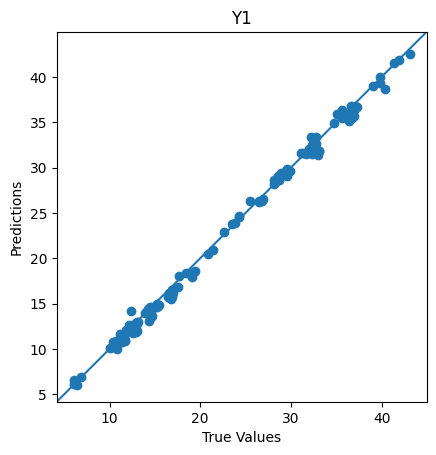

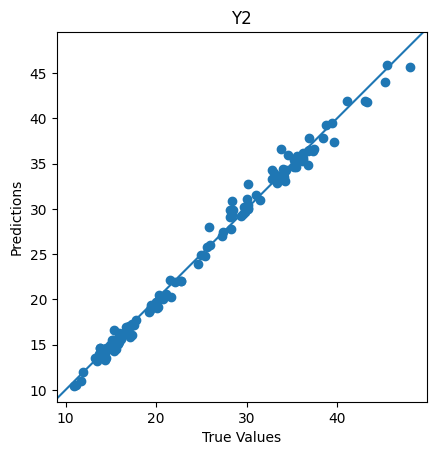

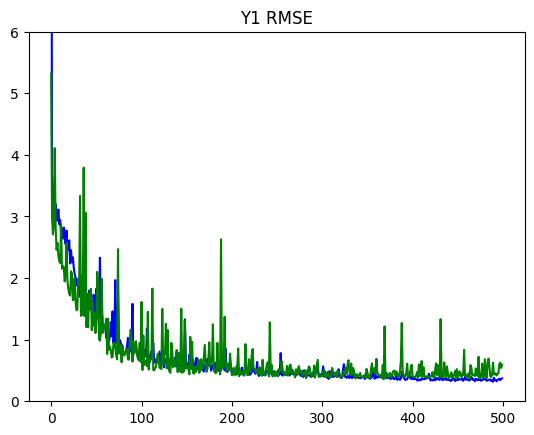

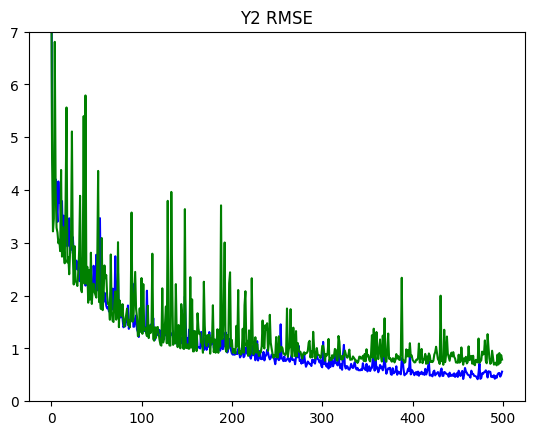

In [18]:
# visualizing the loss and mse 
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title = 'Y1')
plot_diff(test_Y[1], Y_pred[1], title = 'Y2')
plot_metrics(metric_name = 'y1_output_root_mean_squared_error', title = 'Y1 RMSE', ylim = 6)
plot_metrics(metric_name = 'y2_output_root_mean_squared_error', title = 'Y2 RMSE', ylim = 7)